In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
DATASET_DIR = r"D:\shreedhar\Movies\sample3" 
WIENER_K = 0.01

def list_image_files(folder):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif"}
    files = []
    for root, _, filenames in os.walk(folder):
        for f in filenames:
            if os.path.splitext(f)[1].lower() in exts:
                files.append(os.path.join(root, f))
    return sorted(files)

def read_image(path):
    img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise IOError(f"Can't read image: {path}")
    return img.astype(np.float32)

In [6]:
def psf_to_otf(psf, shape):
    psf_pad = np.zeros(shape, dtype=np.float32)
    kh, kw = psf.shape
    psf_pad[:kh, :kw] = psf
    for axis, axis_size in enumerate(psf.shape):
        psf_pad = np.roll(psf_pad, -int(axis_size/2), axis=axis)
    return np.fft.fft2(psf_pad)

def inverse_filter(degraded, psf, eps=1e-6):
    H = psf_to_otf(psf, degraded.shape)
    G = np.fft.fft2(degraded)
    H[np.abs(H) < eps] = eps
    F_hat = G / H
    return np.real(np.fft.ifft2(F_hat))

def wiener_filter(degraded, psf, K=0.01):
    H = psf_to_otf(psf, degraded.shape)
    G = np.fft.fft2(degraded)
    H_conj = np.conj(H)
    F_hat = (H_conj / (np.abs(H) ** 2 + K)) * G
    return np.real(np.fft.ifft2(F_hat))

def make_gaussian_psf(kernel_size=(9,9), sigma=4.0):
    kh, kw = kernel_size
    y = np.arange(-(kh//2), kh//2 + kh%2)
    x = np.arange(-(kw//2), kw//2 + kw%2)
    xx, yy = np.meshgrid(x, y)
    psf = np.exp(-(xx**2 + yy**2) / (2*sigma*sigma))
    psf /= np.sum(psf)
    return psf.astype(np.float32)

In [7]:
def process_image_file(path):
    try:
        degraded = read_image(path)
        psf = make_gaussian_psf((9,9), 4.0)

        inv_res = inverse_filter(degraded, psf)
        wiener_res = wiener_filter(degraded, psf, K=WIENER_K)

        # Clip for display
        degraded_disp = np.clip(degraded, 0, 255).astype(np.uint8)
        inv_disp = np.clip(inv_res, 0, 255).astype(np.uint8)
        wiener_disp = np.clip(wiener_res, 0, 255).astype(np.uint8)

        # 2x2 subplot
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        ax = axes.ravel()
        ax[0].imshow(degraded_disp, cmap='gray')
        ax[0].set_title("Original Image")
        ax[1].imshow(degraded_disp, cmap='gray')
        ax[1].set_title("Degraded Image")
        ax[2].imshow(inv_disp, cmap='gray')
        ax[2].set_title("Inverse Filter Result")
        ax[3].imshow(wiener_disp, cmap='gray')
        ax[3].set_title("Wiener Filter Result")
        for a in ax:
            a.axis('off')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[ERROR] {path}: {e}")

Found 3 images. Processing...


  0%|          | 0/3 [00:00<?, ?it/s]

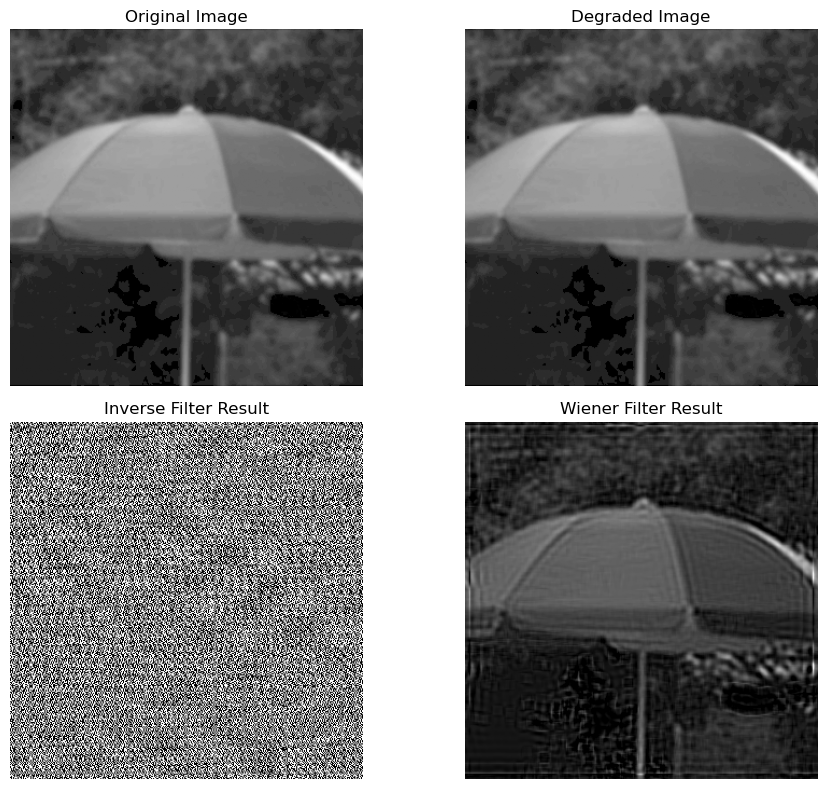

 33%|███▎      | 1/3 [00:00<00:01,  1.58it/s]

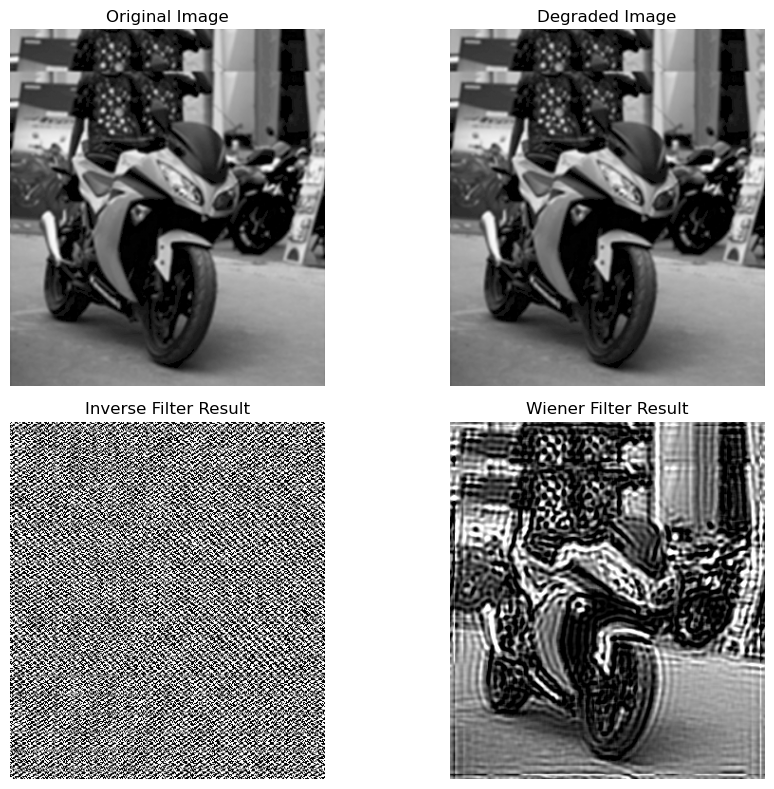

 67%|██████▋   | 2/3 [00:01<00:00,  1.60it/s]

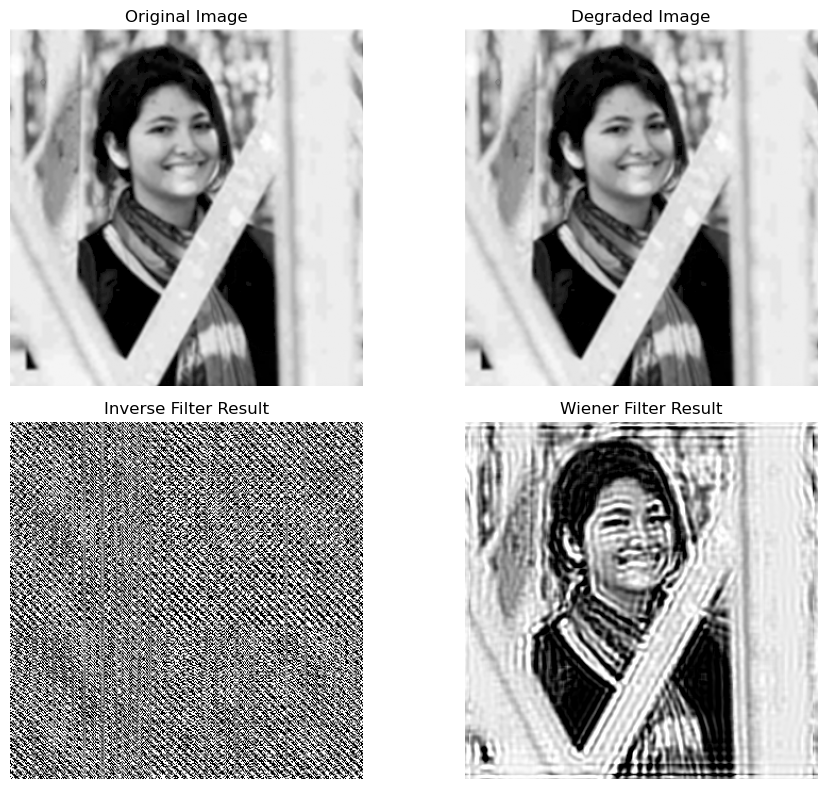

100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

Done.


In [8]:
def main():
    files = list_image_files(DATASET_DIR)
    if not files:
        print("No images found in dataset directory:", DATASET_DIR)
        return
    print(f"Found {len(files)} images. Processing...")
    for f in tqdm(files):
        process_image_file(f)
    print("Done.")

if __name__ == "__main__":
    main()